In [218]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from geopy import distance

In [219]:
SIM_TERRAIN_HEIGHT = -28.0
SIM_SIZE_OFFSET = 10
MODEL_HEIGHT = 1
SIM_ROAD_MINIMAL_HEIGHT = SIM_TERRAIN_HEIGHT + MODEL_HEIGHT
ROAD_WIDTH = 8.0
        

In [220]:
def enrich_with_elevation(points, dataset="eudem25m"):
    
    points_str = [f"{lat},{lon}" for lon, lat in points]
    locations = "|".join(points_str)
    response = requests.get(f"https://api.opentopodata.org/v1/{dataset}?locations={locations}")
    elevations = [p['elevation'] for p in response.json()['results']]

    lons = [x for (x,_) in points]
    lats = [y for (_,y) in points]

    ret = zip(lons, lats, elevations)
    return list(ret)

In [221]:

def get_street_points(street_name,bbox):
    overpass = Overpass()
    query = overpassQueryBuilder(bbox=bbox,
    elementType='way',selector=f'"name"="{street_name}"')

    road_points = []
    for e in overpass.query(query).elements():
        for node in e.nodes():
            road_points.append((node.lon(), node.lat()))

    road_points = enrich_with_elevation(road_points)
    return road_points


In [222]:
SHEFFIELD_BBOX = [53.356987, -1.510101, 53.402656, -1.433196]
KETY_BBOX = [49.839258, 19.153293, 49.920978, 19.305325]
KRAKOW_BBOX = [49.973493, 19.807804, 50.123627, 20.097225]
# geo_points = get_street_points("Abney Street", SHEFFIELD_BBOX)
geo_points = get_street_points("Czaniecka", KETY_BBOX)
print(geo_points)

[(19.257576, 49.8622271, 319.13616943359375), (19.2576442, 49.8623352, 318.88177490234375), (19.2577738, 49.8626507, 317.9229736328125), (19.2578349, 49.8629234, 316.8909912109375), (19.2578477, 49.8630905, 316.21990966796875), (19.2578269, 49.863242, 315.61163330078125), (19.2576378, 49.8638651, 313.501220703125), (19.2576076, 49.8640435, 313.29254150390625), (19.2576014, 49.8646039, 314.5698547363281), (19.2576184, 49.8649705, 314.90338134765625), (19.2575971, 49.865054, 314.7142639160156), (19.2575328, 49.8651341, 314.4497375488281), (19.2574267, 49.8651919, 314.0150451660156), (19.2571815, 49.8652445, 313.13604736328125), (19.2567054, 49.8653025, 311.5503234863281), (19.2564297, 49.8653302, 310.6714782714844), (19.2562537, 49.8653713, 310.0884704589844), (19.2561541, 49.8654394, 309.7017822265625), (19.2560951, 49.8655154, 309.447509765625), (19.2560676, 49.8656287, 309.22271728515625), (19.256082, 49.8663528, 308.3063049316406), (19.2561104, 49.8665442, 308.07684326171875), (19.25

In [223]:
def middle(points):
    return (max(points) + min(points)) / 2


In [224]:
def _geo_to_simulation_points(geo_points):


    # SIM_ROAD_MINIMAL_HEIGHT = 1

    lons = [x for x,_,_ in geo_points] #geo x's
    lats = [y for _,y,_ in geo_points] #geo y's
    els = [z for _,_,z in geo_points] 

    geo_center = np.array((middle(lons), middle(lats)))
    z_offset = min(els)
    sim_points = []

    for x, y, z in geo_points:
        geo_point = np.array([x,y])

        relative_to_geo_center = geo_point-geo_center
        dist = distance.distance(geo_center, geo_point).m
        theta = distance.atan2(relative_to_geo_center[1], relative_to_geo_center[0])

        sim_x = dist * np.cos(theta)
        sim_y = dist * np.sin(theta)
        
        sim_z = z-z_offset+SIM_ROAD_MINIMAL_HEIGHT

        sim_points.append((sim_x, sim_y, sim_z))

    return sim_points

In [225]:
def _get_simulation_size(points):
    points = np.array(points)
    xs = points[:, 0]
    ys = points[:, 1]
    x_range = max(xs)-min(xs)
    y_range = max(ys)-min(ys)
    sim_size = max(x_range, y_range)

    return sim_size + SIM_SIZE_OFFSET

In [226]:
sim_points = _geo_to_simulation_points(geo_points)
sim_size = _get_simulation_size(sim_points)

In [227]:
def _recenter_points(points):
    points = np.array(points)
    points[:, 0:2] += sim_size/2 # x and y values
    return points


In [228]:

sim_points = _recenter_points(sim_points)
print(sim_points)

[[479.71625897   4.97599884  -4.76022339]
 [486.92404831  16.1992004   -5.01461792]
 [500.66818353  49.01773528  -5.97341919]
 [507.19785214  77.44762499  -7.00540161]
 [508.59637711  94.91901872  -7.67648315]
 [506.42077853 110.84686849  -8.28475952]
 [486.45000806 176.65220609 -10.39517212]
 [483.28236267 195.42310428 -10.60385132]
 [482.86003022 254.0755275   -9.32653809]
 [485.01991445 292.31322281  -8.99301147]
 [482.80940103 301.11151228  -9.18212891]
 [475.91830113 309.71202157  -9.44665527]
 [464.47717812 316.1360829   -9.88134766]
 [438.23449198 322.43285411 -10.76034546]
 [387.97840695 328.43143004 -12.34606934]
 [358.19335875 330.36613804 -13.22491455]
 [338.74926708 334.087677   -13.80792236]
 [327.50905578 341.00080373 -14.1946106 ]
 [320.69184893 348.9457026  -14.44888306]
 [317.22744585 361.0254952  -14.67367554]
 [318.01043765 440.47351066 -15.59008789]
 [321.76744508 461.27775184 -15.81954956]
 [330.1730865  481.19201101 -15.96609497]
 [358.06498176 536.13398813 -16.29

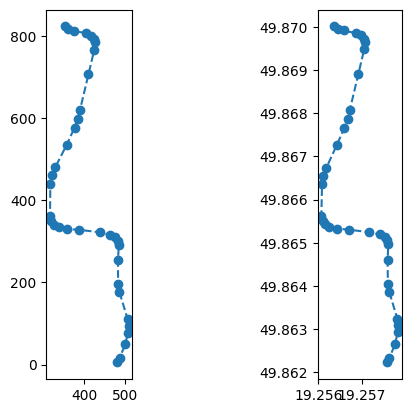

In [229]:
# 
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_aspect('equal', adjustable='box')
ax.ticklabel_format(useOffset=False, style='plain')
xs = [x for x,y,_ in sim_points]
ys = [y for x,y,_ in sim_points]
ax.plot(xs, ys, '--o')

ax = fig.add_subplot(1, 2, 2)
ax.set_aspect('equal', adjustable='box')
ax.ticklabel_format(useOffset=False, style='plain')
xs = [x for x,y,_ in geo_points]
ys = [y for x,y,_ in geo_points]
ax.plot(xs, ys, '--o')

# print(road_points)

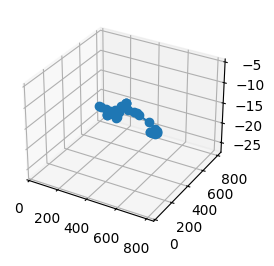

In [230]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlim(0, sim_size)
ax.set_ylim(0, sim_size)
# ax.set_zlim()
xs = [x for x,y,_ in sim_points]
ys = [y for x,y,_ in sim_points]
zs = [z for _,_,z in sim_points]
ax.plot(xs, ys, zs, '--o')


In [231]:
from scipy.interpolate import splprep, splev

def interpolate(points):
    

    xs = [t[0] for t  in points]
    ys = [t[1] for t  in points]
    zs = [t[2] for t  in points]
    
    k=2
    pos_tck, _ = splprep([xs, ys, zs], s=1, k=k)

    N_POINTS = len(points) * 20
    step_size = 1 / N_POINTS
    unew = np.arange(0, 1 + step_size, step_size)

    new_x_vals, new_y_vals, new_z_vals = splev(unew, pos_tck)
    rounding_precision = 10
    # Return the 4-tuple with default z and default road width
    return list(zip([round(v, rounding_precision) for v in new_x_vals],
                    [round(v, rounding_precision) for v in new_y_vals],
                    [round(v, rounding_precision) for v in new_z_vals],
                    ))


In [232]:
def calc_point_edges(p1, p2):
    
    height = p1[2]
    origin = np.array(p1[0:2])
    next = np.array(p2[0:2])

    direction_v = np.subtract(next, origin)

    # calculate the vector which length is half the road width
    v = (direction_v / np.linalg.norm(direction_v)) * ROAD_WIDTH / 2
    # add normal vectors
    left_point = origin + np.array([-v[1], v[0]])
    right_point = origin + np.array([v[1], -v[0]])

    #add origin height
    left_point = np.append(left_point, height)
    right_point = np.append(right_point, height)

    return list(left_point), list(right_point)

def add_road_lanes(points):

    new_points = []
    for i in range(len(points) - 1):
        l, r = calc_point_edges(points[i], points[i + 1])
        new_points.extend([l, r])


    # the last middle point
    l, r = calc_point_edges(points[-1], points[-2])
    new_points.extend([l, r])

    return new_points



In [233]:
print("Size before interpolation:")
print(len(sim_points))
sim_points = interpolate(sim_points)

print("Size after interpolation:")
print(len(sim_points))
sim_points = add_road_lanes(sim_points)

print("Size after adding left and right:")
print(len(sim_points))

Size before interpolation:
36
Size after interpolation:
721
Size after adding left and right:
1442


In [234]:
sim_points = np.array(sim_points)
sim_points

array([[476.45236268,   7.02583227,  -4.7517139 ],
       [483.16617749,   2.67558047,  -4.7517139 ],
       [477.22474176,   8.21763861,  -4.77903594],
       ...,
       [356.29147611, 826.31785367, -26.9815068 ],
       [355.15862624, 827.27014408, -26.98995136],
       [350.01088237, 821.14635987, -26.98995136]])

In [235]:
step = 20

# x = np.arange(0, sim_size, step)
# y = np.arange(0, sim_size, step)
# xs, ys = np.meshgrid(x, y)
# xs = xs.flatten()
# ys = ys.flatten()
# zs = np.full(xs.shape, SIM_TERRAIN_HEIGHT)
# grid_points = np.column_stack((xs, ys, zs))
# print(grid_points.shape)

corners = np.array([[0,0],[0, sim_size], [sim_size, 0], [sim_size, sim_size]])
zs = np.full((4,1), SIM_TERRAIN_HEIGHT)
corners = np.hstack((corners, zs))
print(corners)
grid_points = corners

model_points = np.vstack((sim_points,grid_points))
print(model_points)

[[  0.           0.         -28.        ]
 [  0.         829.24541673 -28.        ]
 [829.24541673   0.         -28.        ]
 [829.24541673 829.24541673 -28.        ]]
[[476.45236268   7.02583227  -4.7517139 ]
 [483.16617749   2.67558047  -4.7517139 ]
 [477.22474176   8.21763861  -4.77903594]
 ...
 [  0.         829.24541673 -28.        ]
 [829.24541673   0.         -28.        ]
 [829.24541673 829.24541673 -28.        ]]


In [236]:
model_points.shape

(1446, 3)

In [237]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(model_points)

In [238]:
o3d.visualization.draw_geometries([pcd])

In [239]:
# pcd.estimate_normals(
#     search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
pcd.estimate_normals()

In [240]:
poisson_mesh = (o3d.geometry.TriangleMesh
    .create_from_point_cloud_poisson
    (pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
    )

In [241]:
type(poisson_mesh)

open3d.cpu.pybind.geometry.TriangleMesh

In [242]:
# o3d.visualization.draw_geometries([poisson_mesh])